<a href="https://colab.research.google.com/github/justinballas/Articles/blob/main/BICFR_Subaccount_Rankings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install xlsxwriter

     |████████████████████████████████| 153kB 4.9MB/s 


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xlsxwriter
%matplotlib inline

     Carrier  ... Prospectus Net Expense Ratio
0    Lincoln  ...                         0.99
3    Lincoln  ...                         0.82
4    Lincoln  ...                         0.72
5    Lincoln  ...                         0.85
6    Lincoln  ...                         0.58
..       ...  ...                          ...
146  Lincoln  ...                         0.84
147  Lincoln  ...                         0.69
148  Lincoln  ...                         0.94
149  Lincoln  ...                         0.74
150  Lincoln  ...                         0.49

[132 rows x 79 columns]
          Carrier  ... Prospectus Net Expense Ratio
0    Pacific Life  ...                         0.34
1    Pacific Life  ...                         0.21
2    Pacific Life  ...                         0.43
3    Pacific Life  ...                         0.58
4    Pacific Life  ...                         0.37
..            ...  ...                          ...
98   Pacific Life  ...                         

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/xlsxwriter/workbook.py:338: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")


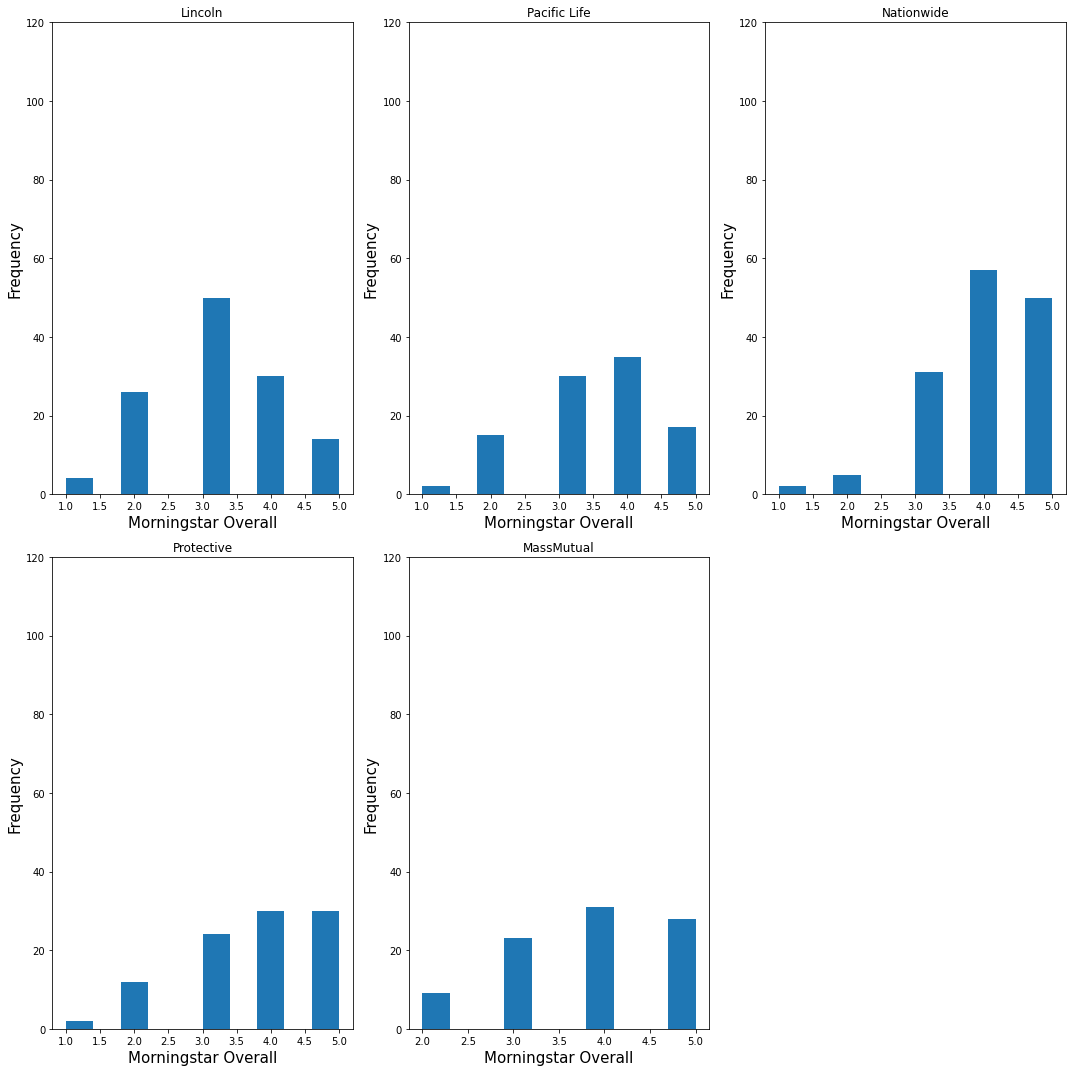

In [61]:
carriers_list = ['MassMutual', 'Protective', 'Nationwide', 'Pacific Life', 'Lincoln']
carriers_list.reverse()
# ,
carrier_dfs = {}
for carrier in carriers_list:
  df = pd.read_excel('Subaccount_Rankings_data_03062021.xlsx', sheet_name=carrier)
  carrier_dfs[carrier] = df
 #skipfooter=13

for carrier, df in carrier_dfs.items():
  df.rename(columns=lambda x: x.replace('\n',''), inplace=True)

#replace_list = ["US Insurance ","US Fund ", "US VUL Sub ", "US VL Sub "]

for carrier in carriers_list:
  temp_df = carrier_dfs[carrier]
  temp_df.drop(temp_df[temp_df['Closed to New Inv']=='Yes'].index, inplace=True)
#  temp_df['Name'] = temp_df['Name'].str.split("-", 1).apply(lambda x: x[1])
#  for phrase in replace_list:
#  temp_df['Morningstar Category'] = temp_df['Morningstar Category'].str.replace(phrase, "")


mnstar_ratings = []
for carrier, df in carrier_dfs.items():
  temp_df = df
  temp_df.insert(loc=0, column='Carrier', value=carrier)
  mnstar_ratings.append(temp_df)
  print(temp_df)

ratings_df = pd.concat(mnstar_ratings)

ratings_df.drop(df[df['Closed to New Inv']=='Yes'].index, inplace=True)

agg_df_carrier = pd.pivot_table(ratings_df, index='Carrier', fill_value=np.nan)

agg_df_class = pd.pivot_table(ratings_df, index='Morningstar Category', fill_value=np.nan)

fig = plt.figure(figsize=[15, 15])



#Creating Hsitogram
for carrier in enumerate(carrier_dfs.keys()):
  temp_df = ratings_df[ratings_df['Carrier']==carrier[1]]
  temp_df = temp_df[['Morningstar Rating Overall','Carrier']]
  ax = fig.add_subplot(2, 3, carrier[0]+1)
  title = temp_df.iloc[0,1]
  plt.ylim(0,120)
  plt.xlabel('Morningstar Overall',fontsize=15)
  plt.ylabel('Frequency',fontsize=15)
  plt.title(title)
  ax.hist(temp_df['Morningstar Rating Overall'])
  plt.tight_layout()

plt.savefig('Carrier Histograms.png')


#Seperating into tables for different sheets
man_tenure = pd.merge(agg_df_carrier['Manager Tenure (Average)'], agg_df_carrier['Manager Tenure (Average)'].rank(ascending=False), how='left', left_index=True, right_index=True,suffixes=('', ' Rank'))

sharpe = pd.merge(agg_df_carrier['Sharpe Ratio 3 Yr (Mo-End) Risk Currency'], agg_df_carrier['Sharpe Ratio 3 Yr (Mo-End) Risk Currency'].rank(ascending=False), how='left', left_index=True, right_index=True,suffixes=('', ' Rank'))

exp_ratio = pd.merge(agg_df_carrier['Prospectus Net Expense Ratio'], agg_df_carrier['Prospectus Net Expense Ratio'].rank(), how='left', left_index=True, right_index=True,suffixes=('', ' Rank'))
ms_ratings_cols = ['Morningstar Rating 10 Yr', 'Morningstar Rating 5 Yr', 'Morningstar Rating 3 Yr', 'Morningstar Rating Overall']
ms_ratings =  agg_df_carrier.loc[:,ms_ratings_cols]



#--------------------------------------
for col in ms_ratings_cols:
  ms_ratings["{} Rank".format(col)] = ms_ratings[col].rank(ascending=False)

#--------------------------------------
rank_cat_cols = ['Total Ret % Rank Cat 1 Yr (Mo-End)', 'Total Ret % Rank Cat 3 Yr (Mo-End)', 'Total Ret % Rank Cat 5 Yr (Mo-End)', 'Total Ret % Rank Cat 10 Yr (Mo-End)']
rank_cat = agg_df_carrier.loc[:, rank_cat_cols]

for col in rank_cat_cols:
  rank_cat["{} Rank".format(col)] = rank_cat[col].rank()

#--------------------------------------
total_ret_cols = ['Total Ret 1 Yr (Mo-End) Base Currency', 'Total Ret Annlzd 3 Yr (Mo-End) Base Currency', 'Total Ret Annlzd 5 Yr (Mo-End) Base Currency', 'Total Ret Annlzd 10 Yr (Mo-End) Base Currency']
total_ret = agg_df_carrier.loc[:, total_ret_cols]

for col in total_ret_cols:
  total_ret["{} Rank".format(col)] = total_ret[col].rank(ascending=False)


#Best in class fund selection
asset_classes = ratings_df['Morningstar Category'].unique()

ratings_df['sum_ratings'] = ratings_df['Morningstar Rating 10 Yr'] + ratings_df['Morningstar Rating 5 Yr'] + ratings_df['Morningstar Rating 3 Yr'] + ratings_df['Morningstar Rating Overall']


ratings_df['avg_rankings'] = (ratings_df['Total Ret % Rank Cat 1 Yr (Mo-End)'] + ratings_df['Total Ret % Rank Cat 3 Yr (Mo-End)'] + ratings_df['Total Ret % Rank Cat 5 Yr (Mo-End)'] + ratings_df['Total Ret % Rank Cat 10 Yr (Mo-End)'])/4

ratings_df['total_score'] = ratings_df['sum_ratings'] + ratings_df['avg_rankings'].apply(lambda x: 1-(x/100))

bicf_list = []
for carrier in carriers_list:
  temp_df = ratings_df[ratings_df['Carrier']==carrier]
  for asset_class in asset_classes:
    class_df = temp_df[temp_df['Morningstar Category']==asset_class]
    class_df['BICF'] = ['yes' if i == class_df['total_score'].max() else 'no' for i in class_df['total_score']]
    bicf_list.append(class_df)
    
ratings_df = pd.concat(bicf_list)

man_tenure = man_tenure.transpose()
ms_ratings = ms_ratings.transpose()
sharpe = sharpe.transpose()
exp_ratio = exp_ratio.transpose()
rank_cat = rank_cat.transpose()
total_ret = total_ret.transpose()


#writing to excel
xlwriter = pd.ExcelWriter('BICFR Subaccount Rankings Python Output.xlsx', engine='xlsxwriter')

man_tenure.to_excel(xlwriter, sheet_name='Manager Tenure')
ms_ratings.to_excel(xlwriter, sheet_name='Ratings')
sharpe.to_excel(xlwriter, sheet_name='Sharpe')
exp_ratio.to_excel(xlwriter, sheet_name='Expense Ratio')
rank_cat.to_excel(xlwriter, sheet_name='Return Rankings')
total_ret.to_excel(xlwriter, sheet_name='Total Return')

agg_df_class.to_excel(xlwriter, sheet_name='Asset Class Breakdown')

bicf_df = ratings_df[ratings_df['BICF']=='yes']
bicf_df.set_index(['Carrier','Morningstar Category'], inplace=True)
bicf_df.to_excel(xlwriter, sheet_name='BICFR')

ratings_df.set_index(['Carrier', 'Name'], inplace=True)
ratings_df.to_excel(xlwriter, sheet_name='All Data')

empty_sheet = pd.DataFrame()
empty_sheet.to_excel(xlwriter, sheet_name='Histogram')
worksheet=xlwriter.sheets['Histogram']
worksheet.insert_image('B2','Carrier Histograms.png')

counter = 0
for i in range(len(carriers_list)):
  list(carrier_dfs.values())[i].to_excel(xlwriter, sheet_name='{}'.format(carriers_list[i]))

xlwriter.save()

xlwriter.close()

In [60]:
carriers_list.reverse()
carriers_list

['Lincoln', 'Nationwide', 'Protective', 'MassMutual']

In [14]:
(carriers_list = ['MassMutual', 'Protective', 'Nationwide', 'Pacific Life', 'Lincoln']

carrier_dfs = {}
for carrier in carriers_list:
  df = pd.read_excel('Subaccount_Rankings_data_03062021.xlsx', sheet_name=carrier)
  carrier_dfs[carrier] = df
 #skipfooter=13

for carrier, df in carrier_dfs.items():
  df.rename(columns=lambda x: x.replace('\n',''), inplace=True)

replace_list = ["US Insurance ","US Fund ", "US VUL Sub ", "US VL Sub "]

for carrier in carriers_list:
  temp_df = carrier_dfs[carrier]
  temp_df.drop(temp_df[temp_df['Closed to New Inv']=='Yes'].index, inplace=True)
  #temp_df.index = temp_df.index.str.split("-", 1).apply(lambda x: x[1])
  for phrase in replace_list:
    temp_df['Morningstar Category'] = temp_df['Morningstar Category'].str.replace(phrase, "")
  print(list(temp_df['Name']))

['MML Electrm-American Century VP Capital Apprec I', 'MML Electrm-American Century VP Inflation Prot II', 'MML Electrm-American Century VP International I', 'MML Electrm-BlackRock Basic Value V.I. 1', 'MML Electrm-BlackRock High Yield V.I. I', 'MML Electrm-BlackRock Small Cap Index V.I. III', 'MML Electrm-BlackRock Total Return V.I. I', 'MML Electrm-BNY Mellon IP MidCap Stock Svc', 'MML Electrm-Delaware VIP Emerging Markets Svc', 'MML Electrm-Delaware VIP Small Cap Value Series Svc', 'MML Electrm-Eaton Vance VT Floating-Rate Inc ADV', 'MML Electrm-Fidelity VIP Freedom® 2020 Svc', 'MML Electrm-Fidelity VIP Freedom® 2025 Svc', 'MML Electrm-Fidelity VIP Freedom® 2030 Svc', 'MML Electrm-Fidelity VIP Freedom® 2035 Svc', 'MML Electrm-Fidelity VIP Freedom® 2040 Svc', 'MML Electrm-Fidelity VIP Freedom® 2045 Svc', 'MML Electrm-Fidelity VIP Freedom® 2050 Svc', 'MML Electrm-Fidelity VIP Freedom® 2055 Service', 'MML Electrm-Fidelity VIP Freedom® 2060 Service', 'MML Electrm-Fidelity VIP Freedom® In

In [31]:
df = carrier_dfs['Pacific Life']

In [32]:
df['Name'] = df['Name'].apply(lambda x: x.split("-", 1))

AttributeError: ignored

In [33]:
df

,Name,Morningstar Category,Advisor,Subadvisor,Total Ret 1 Yr (Mo-End) Base Currency,Total Ret Annlzd 3 Yr (Mo-End) Base Currency,Total Ret Annlzd 5 Yr (Mo-End) Base Currency,Total Ret Annlzd 10 Yr (Mo-End) Base Currency,Morningstar Rating Overall,Morningstar Rating 3 Yr,Morningstar Rating 5 Yr,Morningstar Rating 10 Yr,Total Ret % Rank Cat 1 Yr (Mo-End),Total Ret % Rank Cat 3 Yr (Mo-End),Total Ret % Rank Cat 5 Yr (Mo-End),Total Ret % Rank Cat 10 Yr (Mo-End),Manager Tenure (Average),Total Net Expense,Sharpe Ratio 3 Yr (Mo-End) Risk Currency,Std Dev 3 Yr (Mo-End) Risk Currency,Yield to Maturity,Modified Duration,Ticker,Underlying Fund CUSIP,Closed to New Inv,Total Ret YTD (Daily) Base Currency,Total Ret YTD (Mo-End) Base Currency,Total Ret Inception (Mo-End) Base Currency,Inception Date,Sustainable Investment - ESG Fund Overall 2018-03,Sustainable Investment - ESG Fund Overall 2018-04,Sustainable Investment - ESG Fund Overall 2018-05,Sustainable Investment - ESG Fund Overall 2018-06,Sustainable Investment - ESG Fund Overall 2018-07,Sustainable Investment - ESG Fund Overall 2018-08,Sustainable Investment - ESG Fund Overall 2018-09,Sustainable Investment - ESG Fund Overall 2018-10,Sustainable Investment - ESG Fund Overall 2018-11,Sustainable Investment - ESG Fund Overall 2018-12,Sustainable Investment - ESG Fund Overall 2019-01,Sustainable Investment - ESG Fund Overall 2019-02,Sustainable Investment - ESG Fund Overall 2019-03,Sustainable Investment - ESG Fund Overall 2019-04,Sustainable Investment - ESG Fund Overall 2019-05,Sustainable Investment - ESG Fund Overall 2019-06,Sustainable Investment - ESG Fund Overall 2019-07,Sustainable Investment - ESG Fund Overall 2019-08,Sustainable Investment - ESG Fund Overall 2019-09,Sustainable Investment - ESG Fund Overall 2019-10,Sustainable Investment - ESG Fund Overall 2019-11,Sustainable Investment - ESG Fund Overall 2019-12,Sustainable Investment - ESG Fund Overall 2020-01,Sustainable Investment - ESG Fund Overall 2020-02,Sustainable Investment - ESG Fund Overall 2020-03,Sustainable Investment - ESG Fund Overall 2020-04,Sustainable Investment - ESG Fund Overall 2020-05,Sustainable Investment - ESG Fund Overall 2020-06,Sustainable Investment - ESG Fund Overall 2020-07,Sustainable Investment - ESG Fund Overall 2020-08,Sustainable Investment - ESG Fund Overall 2020-09,Sustainable Investment - ESG Fund Overall 2020-10,Sustainable Investment - ESG Fund Overall 2020-11,Sustainable Investment - ESG Fund Overall 2020-12,Sustainable Investment - ESG Fund Overall 2021-01,Sustainable Investment - ESG Fund Overall 2021-02,Portfolio Sustainability Score,Morningstar Sustainability Rating™,Portfolio Environmental Risk Score,Portfolio Social Risk Score,Portfolio Governance Risk Score,Percent of AUM Covered - ESG,Percent of AUM Covered - Controversy,Historical Sustainability Score,Annual Report Net Expense Ratio Year2018,Annual Report Net Expense Ratio Year2019,Annual Report Net Expense Ratio Year2020,Annual Report Net Expense Ratio,Prospectus Net Expense Ratio
0,Fidelity® VIP Government Money Mkt Svc,Money Market - Taxable,Fidelity Management & Research Company LLC,FMR Investment Management (U.K.) Limited;Fidel...,0.010000,1.090000,0.880000,0.450000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.330000,NaN,-3.810000,0.270000,NaN,NaN,NaN,NaN,No,0.000000,0.000000,1.520000,2000-07-07 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NaN,NaN,NaN,NaN,NaN,35.220000,35.220000,NaN,0.360000,0.36000,0.230000,0.230000,0.340000
1,DFA VA Short-Term Fixed Portfolio,Ultrashort Bond,Dimensional Fund Advisors LP,Dimensional Fund Advisors Ltd;DFA Australia Li...,0.010000,1.460000,1.200000,0.810000,2.000000,2.000000,2.000000,2.000000,94.000000,82.000000,84.000000,81.000000,11.780000,NaN,0.810000,0.390000,0.120000,NaN,NaN,NaN,No,0.000000,0.000000,2.600000,1995-10-03 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,